**Review**

Hi, my name is Dmitry and I will be reviewing your code.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job overall! Nice work on data preprocessing and feature engineering as well as modeling. There is only one small problem: the way you calculated ROC-AUC may lead to it being slightly underestimated. But you beat the 6 SP threshold anyway. Congratulations!

# Interconnect Customer Analysis

In order to assist Intercom, a telecommunications and internet provider, we will be analyzing customer data in order to create aa model with machine learning to help aid in the evaluation and identification of customers who will likely churn, or end their contracts.

We will carry out an exploratory analysis of the data with visual representations of the data to try and identify patterns or trends. Then the data will be optimized for and used to train machine learning models, of which the best will be selected, to identify the customers that will likely churn.

Our assessment metric for this task is ROC-AUC, or the Area Under Curve (AUC) of the Recieving Operator Characteristic (ROC). The closer to 1 the ROC-AUC score, the better the model's ability to predict accurately.

## Load Data and Libraries

In [1]:
### Import libraries and data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Loading for TripleTen on-platform use

# df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
# df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
# df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
# df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Loading for personal directory

df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

## Data Overview and Preprocessing

### `df_contract`

#### Overview

In [2]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


#### Preprocessing

In [4]:
### Convert column names to snake_script
df_contract = df_contract.rename(columns={'customerID' : 'customer_id', 'BeginDate' : 'begin_date', 'EndDate' : 'end_date', 'Type' : 'contract_type', 'PaperlessBilling' : 'paperless_billing', 'PaymentMethod' : 'payment_method', 'MonthlyCharges' : 'monthly_charges', 'TotalCharges' : 'total_charges'})

In [5]:
### Convert Month-to-month to Monthly
df_contract['contract_type'] = df_contract['contract_type'].where(df_contract['contract_type'] != 'Month-to-month', 'Monthly')

In [6]:
### Convert begin_date to datetime
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [7]:
### Convert end_date to datetime
df_contract['end_date'] = df_contract['end_date'].where(df_contract['end_date'] != 'No', None)
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

In [8]:
### Create contract duration column
duration = ((df_contract['end_date'] - df_contract['begin_date']) / np.timedelta64(1, 'M'))
df_contract['contract_duration_months'] = duration.round()

In [9]:
### Create churned column
df_contract['churned'] = df_contract['contract_duration_months']
df_contract['churned'] = df_contract['churned'].fillna(0)
df_contract['churned'] = df_contract['churned'].where(df_contract['churned'] < 0.5, 1)
df_contract['churned'] = df_contract['churned'].astype(int)

In [10]:
### paperless_billing to 1/0
df_contract['paperless_billing'] = df_contract['paperless_billing'].where(df_contract['paperless_billing'] != 'Yes', 1)
df_contract['paperless_billing'] = df_contract['paperless_billing'].where(df_contract['paperless_billing'] != 'No', 0)
df_contract['paperless_billing'] = df_contract['paperless_billing'].astype(int)

In [11]:
### total_charges to float
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

In [12]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   object        
 4   paperless_billing         7043 non-null   int32         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7032 non-null   float64       
 8   contract_duration_months  1869 non-null   float64       
 9   churned                   7043 non-null   int32         
dtypes: datetime64[ns](2), float64(3), int32(2), object(3)
memory usage: 495.3+ KB


In [13]:
df_contract.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned
0,7590-VHVEG,2020-01-01,NaT,Monthly,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Monthly,1,Mailed check,53.85,108.15,2.0,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01,Monthly,1,Electronic check,70.70,151.65,2.0,1


In [14]:
df_contract.duplicated().sum()

0

The column names in `df_contacts` were changed to snake_script to be consistent with the other dataframes for when they are merged. `Contract` was changed to `contract_type` to be easier to translate on the larger table, along with "Month-to-month" changed to "Monthly" within the `payment_method column`. Binary entried of yea/no were changed to 1/0 to save time with future adjustments when preparing to train models. And dates in columns were switched to datetime format.

Two columns were createded, `contract_duration_months` which shows the duration of churned contracts in months, and `churned` which shows a 1 if customers have ended their contract, or 0 if they are still current.

### `df_personal`

#### Overview

In [15]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


#### Preprocessing

In [17]:
### Convert column names to snake_script
df_personal = df_personal.rename(columns={'customerID' : 'customer_id','gender' : 'gender_male' , 'SeniorCitizen' : 'senior_citizen', 'Partner' : 'partner', 'Dependents' : 'dependents'})

In [18]:
### gender_male to 1/0
df_personal['gender_male'] = df_personal['gender_male'].where(df_personal['gender_male'] != 'Male', 1)
df_personal['gender_male'] = df_personal['gender_male'].where(df_personal['gender_male'] != 'Female', 0)
df_personal['gender_male'] = df_personal['gender_male'].astype(int)

In [19]:
### partner to 1/0
df_personal['partner'] = df_personal['partner'].where(df_personal['partner'] != 'Yes', 1)
df_personal['partner'] = df_personal['partner'].where(df_personal['partner'] != 'No', 0)
df_personal['partner'] = df_personal['partner'].astype(int)

In [20]:
### dependents to 1/0
df_personal['dependents'] = df_personal['dependents'].where(df_personal['dependents'] != 'Yes', 1)
df_personal['dependents'] = df_personal['dependents'].where(df_personal['dependents'] != 'No', 0)
df_personal['dependents'] = df_personal['dependents'].astype(int)

In [21]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender_male     7043 non-null   int32 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int32 
 4   dependents      7043 non-null   int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 192.7+ KB


In [22]:
df_personal.head()

,customer_id,gender_male,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [23]:
df_personal.duplicated().sum()

0

Column names have been adjusted to snake_script to match other dataframes. The `Gender` columns was changed to `gender_male` to save of future feature engineering, male are value 1, female are value 0. All other yes/no columns have been changed to 1/0.

### `df_internet`

#### Overview

In [24]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


#### Preprocessing

[x] Convert column names to snake_script

[x] Convert Yes/No values to 1/0

In [26]:
### Convert column names to snake_script
df_internet = df_internet.rename(columns={'customerID' : 'customer_id','InternetService' : 'internet_service' , 'OnlineSecurity' : 'online_security', 'OnlineBackup' : 'online_backup', 'DeviceProtection' : 'device_protection', 'TechSupport' : 'tech_support', 'StreamingTV' : 'streaming_tv', 'StreamingMovies' : 'streaming_movies'})

In [27]:
### Yes/No columns to 1/0
df_internet = df_internet.where(df_internet != 'Yes', 1)
df_internet = df_internet.where(df_internet != 'No', 0)
df_internet['online_security'] = df_internet['online_security'].astype(int)
df_internet['online_backup'] = df_internet['online_backup'].astype(int)
df_internet['device_protection'] = df_internet['device_protection'].astype(int)
df_internet['tech_support'] = df_internet['tech_support'].astype(int)
df_internet['streaming_tv'] = df_internet['streaming_tv'].astype(int)
df_internet['streaming_movies'] = df_internet['streaming_movies'].astype(int)

In [28]:
### Create has_internet 1/0
has_internet = df_internet['streaming_movies']
df_internet['has_internet'] = has_internet
df_internet['has_internet'] = df_internet['has_internet'].where(df_internet['has_internet'] < 0, 1)

In [29]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int32 
 3   online_backup      5517 non-null   int32 
 4   device_protection  5517 non-null   int32 
 5   tech_support       5517 non-null   int32 
 6   streaming_tv       5517 non-null   int32 
 7   streaming_movies   5517 non-null   int32 
 8   has_internet       5517 non-null   int32 
dtypes: int32(7), object(2)
memory usage: 237.2+ KB


In [30]:
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,has_internet
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1


In [31]:
df_internet.duplicated().sum()

0

Column names have been converted to snake_script to remain consistent. Yes/No values have been changed to 1/0. An additional column has also been made indicating that the customers on this list have internet service as it is easier at this phase than while prepping for machine learning after the dataframes have been merged.

### `df_phone`

#### Overview

In [32]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Preprocessing

In [34]:
### Convert column names to snake_script
df_phone = df_phone.rename(columns={'customerID' : 'customer_id','MultipleLines' : 'multiple_lines'})

In [35]:
### Yes/No columns to 1/0
df_phone = df_phone.where(df_phone != 'Yes', 1)
df_phone = df_phone.where(df_phone != 'No', 0)
df_phone['multiple_lines'] = df_phone['multiple_lines'].astype(int)

In [36]:
### Add phone_service column as feature engineering
phone_service = df_phone['multiple_lines']
df_phone['phone_service'] = phone_service
df_phone['phone_service'] = df_phone['phone_service'].where(df_phone['phone_service'] < 0, 1)

In [37]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int32 
 2   phone_service   6361 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 99.5+ KB


In [38]:
df_phone.head()

,customer_id,multiple_lines,phone_service
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


In [39]:
df_phone.duplicated().sum()

0

Column names have been converted to snake_script to remain consistent. Yes/No values have been changed to 1/0.

### Create `df_complete`

#### Merge dataframes

In [40]:
df_complete = df_contract.merge(df_personal, on='customer_id', how='outer')
df_complete = df_complete.merge(df_internet, on='customer_id', how='outer')
df_complete = df_complete.merge(df_phone, on='customer_id', how='outer')

The four separate dataframes have been merged into one singular dataframe for ease of use.

#### Overview

In [41]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   object        
 4   paperless_billing         7043 non-null   int32         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7032 non-null   float64       
 8   contract_duration_months  1869 non-null   float64       
 9   churned                   7043 non-null   int32         
 10  gender_male               7043 non-null   int32         
 11  senior_citizen            7043 non-null   int64         
 12  partner             

In [42]:
df_complete.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,has_internet,multiple_lines,phone_service
0,7590-VHVEG,2020-01-01,NaT,Monthly,1,Electronic check,29.85,29.85,NaN,0,...,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Monthly,1,Mailed check,53.85,108.15,2.0,1,...,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Monthly,1,Electronic check,70.70,151.65,2.0,1,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### Preprocessing of `df_complete`

In [43]:
df_complete.isna().sum()

customer_id                    0
begin_date                     0
end_date                    5174
contract_type                  0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                 11
contract_duration_months    5174
churned                        0
gender_male                    0
senior_citizen                 0
partner                        0
dependents                     0
internet_service            1526
online_security             1526
online_backup               1526
device_protection           1526
tech_support                1526
streaming_tv                1526
streaming_movies            1526
has_internet                1526
multiple_lines               682
phone_service                682
dtype: int64

In [44]:
df_complete[df_complete['total_charges'].isna()]

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,has_internet,multiple_lines,phone_service
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN,NaN,0,...,DSL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN,NaN,0,...,DSL,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,NaN,NaN,0,...,DSL,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,NaN,NaN,0,...,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [45]:
df_complete['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

In [46]:
df_complete['total_charges'] = df_complete['total_charges'].fillna(0)

In [47]:
df_complete['internet_service'] = df_complete['internet_service'].fillna('No Service')

In [48]:
df_complete['online_security'] = df_complete['online_security'].fillna(0)
df_complete['online_security'] = df_complete['online_security'].astype(int)

In [49]:
df_complete['online_backup'] = df_complete['online_backup'].fillna(0)
df_complete['online_backup'] = df_complete['online_backup'].astype(int)

In [50]:
df_complete['device_protection'] = df_complete['device_protection'].fillna(0)
df_complete['device_protection'] = df_complete['device_protection'].astype(int)

In [51]:
df_complete['tech_support'] = df_complete['tech_support'].fillna(0)
df_complete['tech_support'] = df_complete['tech_support'].astype(int)

In [52]:
df_complete['streaming_tv'] = df_complete['streaming_tv'].fillna(0)
df_complete['streaming_tv'] = df_complete['streaming_tv'].astype(int)

In [53]:
df_complete['streaming_movies'] = df_complete['streaming_movies'].fillna(0)
df_complete['streaming_movies'] = df_complete['streaming_movies'].astype(int)

In [54]:
df_complete['multiple_lines'] = df_complete['multiple_lines'].fillna(0)
df_complete['multiple_lines'] = df_complete['multiple_lines'].astype(int)

In [55]:
df_complete['phone_service'] = df_complete['phone_service'].fillna(0)
df_complete['phone_service'] = df_complete['phone_service'].astype(int)

In [56]:
df_complete['has_internet'] = df_complete['has_internet'].fillna(0)
df_complete['has_internet'] = df_complete['has_internet'].astype(int)

In [57]:
df_complete.isna().sum()

customer_id                    0
begin_date                     0
end_date                    5174
contract_type                  0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                  0
contract_duration_months    5174
churned                        0
gender_male                    0
senior_citizen                 0
partner                        0
dependents                     0
internet_service               0
online_security                0
online_backup                  0
device_protection              0
tech_support                   0
streaming_tv                   0
streaming_movies               0
has_internet                   0
multiple_lines                 0
phone_service                  0
dtype: int64

Those Customer IDs that have no value for `total_charges` were those with a begin date of 2020-02-01, which is the latest date. It indicates that they have signed up for a service, but have not been charged yet, making the total charges to their accounts 0.

The missing values in `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, and `multiple_lines` indicate that the customer did not have the service. Missing values in `internet_service` were replaced with "No Service" as this column contained other strings such as "DSL" or "Fiber Optic", the rest of the aforementioned columns had their missing values filled with "0" as this indicates that they did not have this particular service.

`end_date` and `contract_duration_months` still contain missing values as these only refer to customers that have churned.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job on data preprocessing! Dataframes were merged correctly

</div>

## Exploratory Analysis

In [60]:
plt.style.use('seaborn')

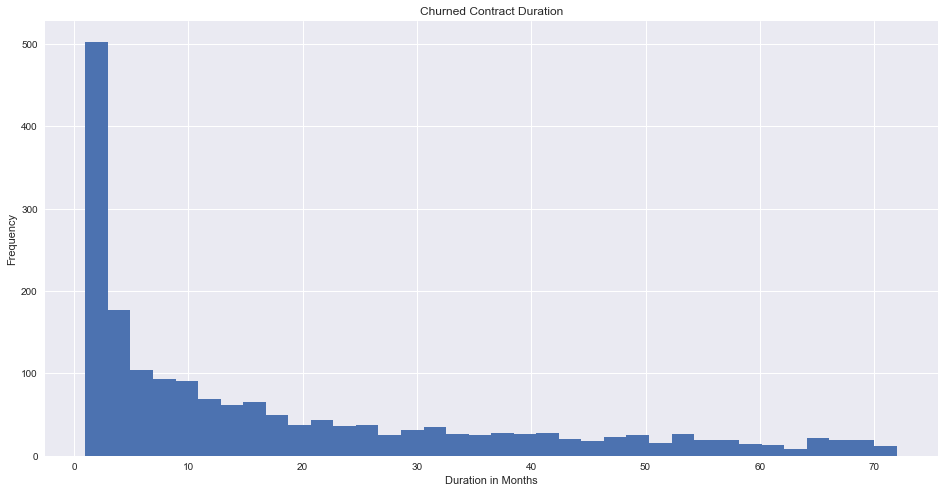

In [61]:
df_complete['contract_duration_months'].plot(kind='hist', bins=36, title='Churned Contract Duration', figsize=[16,8])
plt.xlabel('Duration in Months')
plt.xticks(rotation=0)
plt.show()

A vast majority of churned customers ended their contracts in less than a year, the greatest quantity ending after only a month or two.

In [62]:
eda2 = df_complete.pivot_table(columns='churned',
                               index='contract_type',
                               values='customer_id',
                               aggfunc='count'
                              )
eda2.reset_index(inplace=True)

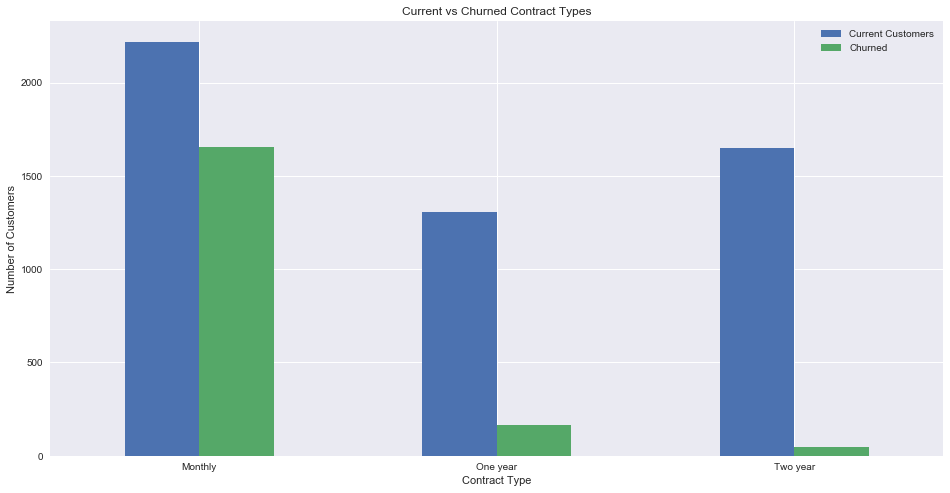

In [63]:
eda2.plot(kind='bar',
          x='contract_type',
          title='Current vs Churned Contract Types',
          figsize=[16,8],
         )

plt.xticks(rotation= 0)
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])
plt.show()

In [64]:
eda3 = df_complete.pivot_table(columns='churned',
                               index='payment_method',
                               values='contract_type',
                               aggfunc='count'
                              )
eda3.reset_index(inplace=True)

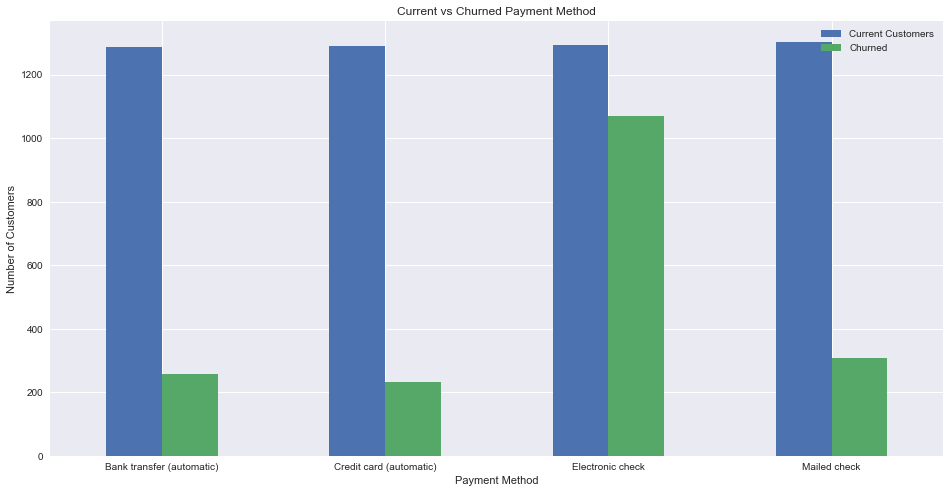

In [65]:
eda3.plot(kind='bar',
          x='payment_method',
          title='Current vs Churned Payment Method',
          figsize=[16,8],
         )

plt.xticks(rotation= 0)
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])
plt.show()

The distribution of current customers is relatively equal between the four different payment options. The highest number and proportion of customers that have churned used electronic checks to pay. Automatic bank transfer, automatic credit card charge, and mailed checks show to be a smaller proportion overall.

In [66]:
eda4a = df_complete.pivot_table(columns='churned',
                                index='customer_id',
                                values='monthly_charges'
                               )
eda4a.reset_index(inplace=True)
eda4a.drop(labels='customer_id', axis=1, inplace=True)

eda4b = df_complete.pivot_table(columns='churned',
                                index='customer_id',
                                values='total_charges'
                               )
eda4b.reset_index(inplace=True)
eda4b.drop(labels='customer_id', axis=1, inplace=True)

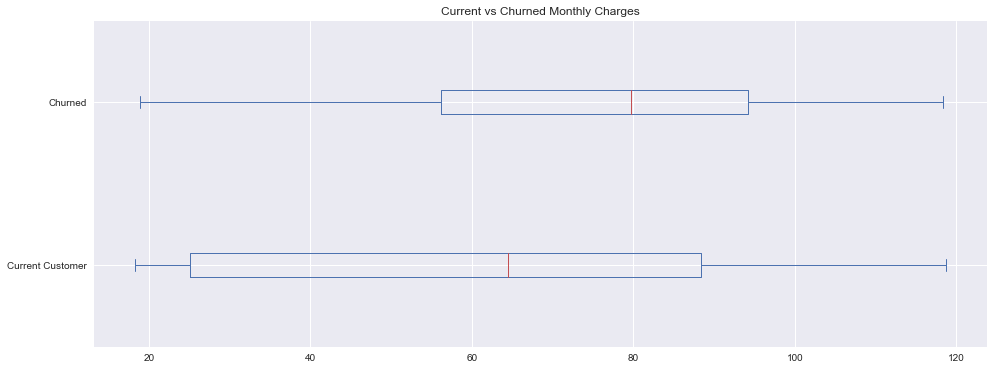

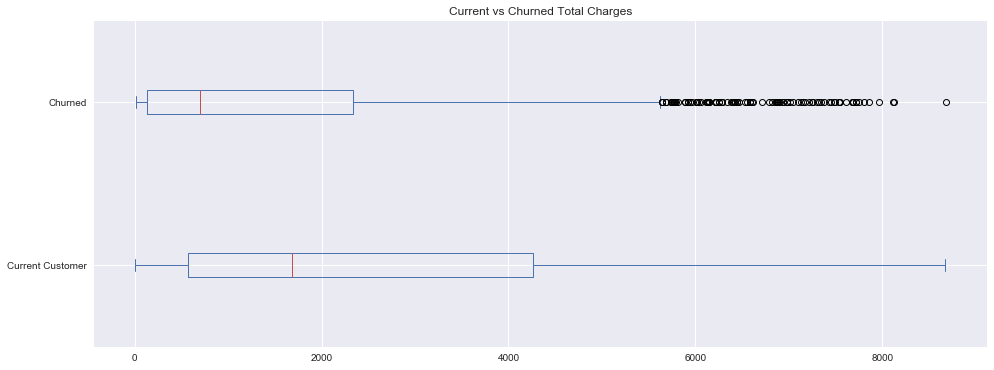

In [67]:
eda4a.plot(kind='box',
           figsize=[16,6],
           title='Current vs Churned Monthly Charges',
           vert=False
          )
plt.yticks([1, 2], ['Current Customer', 'Churned'])
eda4b.plot(kind='box',
           figsize=[16,6],
           title='Current vs Churned Total Charges',
           vert=False
          )
plt.yticks([1, 2], ['Current Customer', 'Churned'])
plt.show()

By the quartile distributions above, we can see that the average monthly contract of customers that have churned tended to be higher than that of current customers, approximately 80 dollars compared to approximately 65 dollars.

Where total charges are concerned, all current customers fall within the quartile bounds with no outliers, while churned customers have spent less money on average, but the upper extents, from approximately $5600 and up are considered outliers for those customers that have churned.

In [68]:
eda5a = df_complete.pivot_table(columns='churned',
                               index='gender_male',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda5a.reset_index(inplace=True)

eda5b = df_complete.pivot_table(columns='churned',
                               index='senior_citizen',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda5b.reset_index(inplace=True)

eda5c = df_complete.pivot_table(columns='churned',
                               index='partner',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda5c.reset_index(inplace=True)

eda5d = df_complete.pivot_table(columns='churned',
                               index='dependents',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda5d.reset_index(inplace=True)

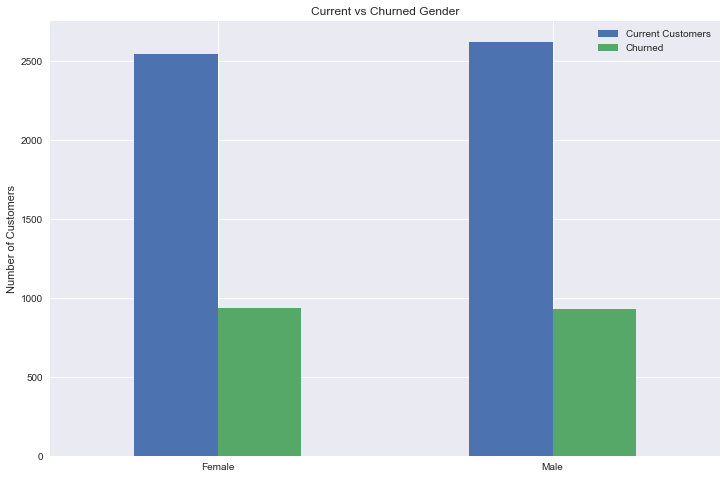

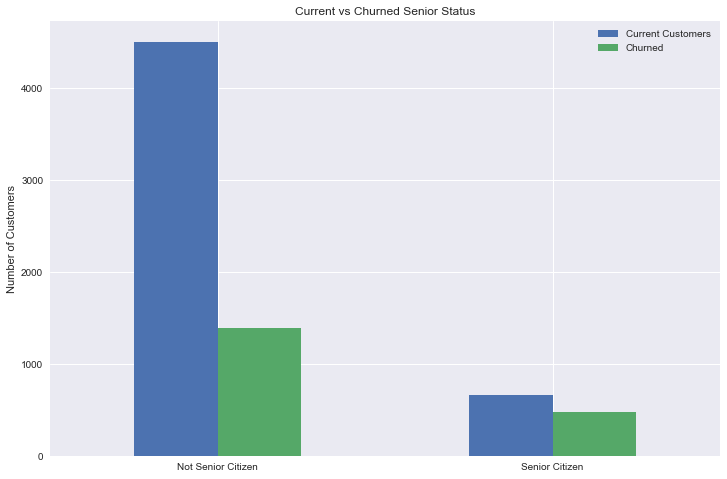

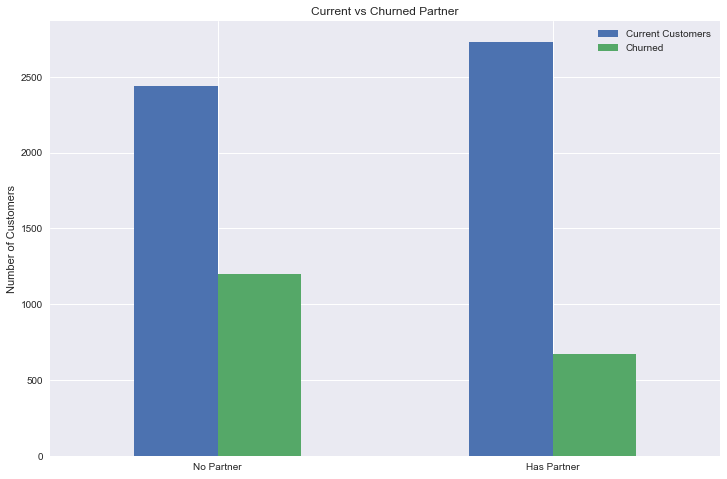

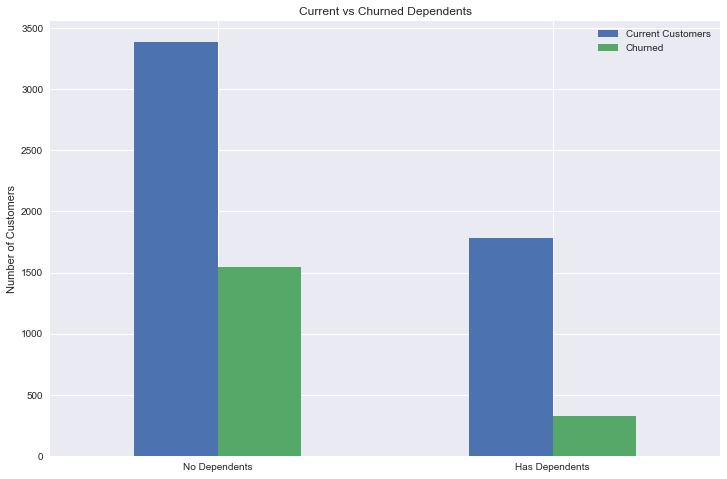

In [69]:
eda5a.plot(kind='bar',
           x='gender_male',
           title='Current vs Churned Gender',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['Female', 'Male'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda5b.plot(kind='bar',
           x='senior_citizen',
           title='Current vs Churned Senior Status',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['Not Senior Citizen', 'Senior Citizen'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda5c.plot(kind='bar',
           x='partner',
           title='Current vs Churned Partner',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Partner', 'Has Partner'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda5d.plot(kind='bar',
           x='dependents',
           title='Current vs Churned Dependents',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Dependents', 'Has Dependents'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

plt.show()

The demographics of the customers holds to a similar distribution of current customers being between two to four times the number of churned customers in most cases.

The notable exceptions are a higher proportion of senior citizens that churned, which my be caused by a higher number of such customers passing away, therefore their contrants would be cancelled.

There is also a much lower proportion of churned customers where there are dependents or partners reported as well. This could be that those customers/households hold to a steady budget - so having a constant contract is more convenient and beneficial for their social situation.

In [70]:
eda6a = df_complete.pivot_table(columns='contract_type',
                               index='gender_male',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda6a.reset_index(inplace=True)

eda6b = df_complete.pivot_table(columns='contract_type',
                               index='senior_citizen',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda6b.reset_index(inplace=True)

eda6c = df_complete.pivot_table(columns='contract_type',
                               index='partner',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda6c.reset_index(inplace=True)

eda6d = df_complete.pivot_table(columns='contract_type',
                               index='dependents',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda6d.reset_index(inplace=True)

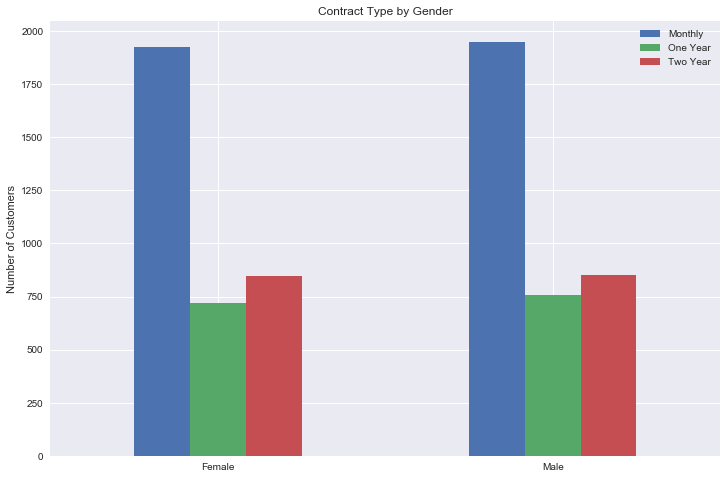

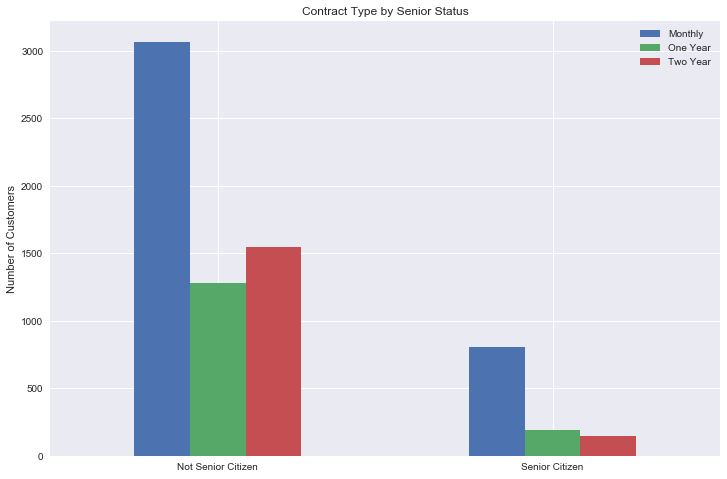

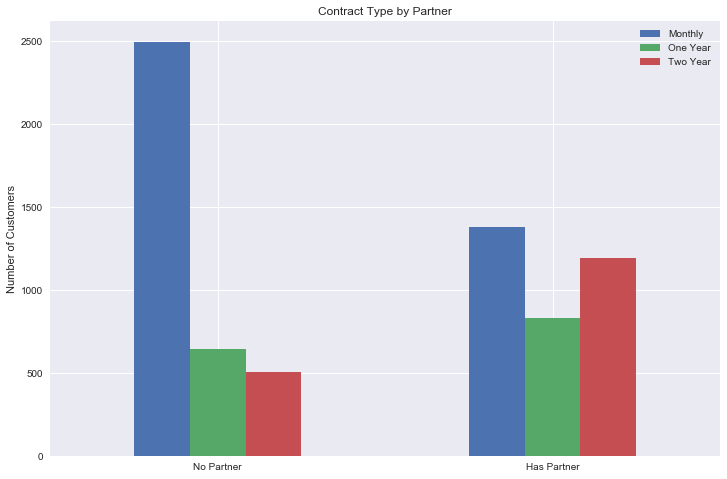

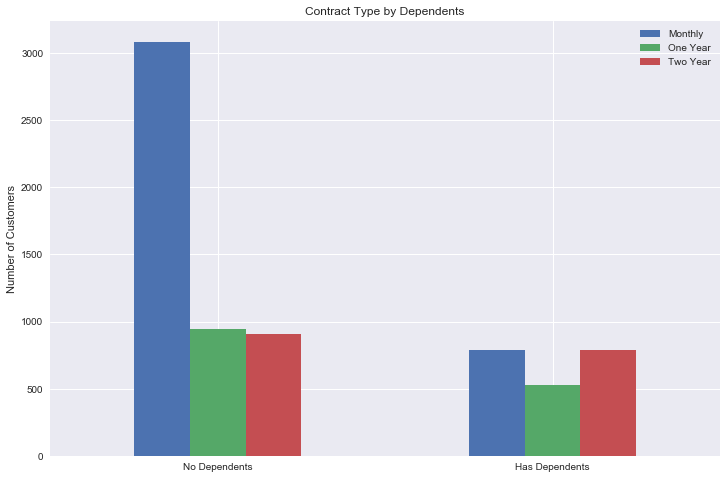

In [71]:
eda6a.plot(kind='bar',
           x='gender_male',
           title='Contract Type by Gender',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['Female', 'Male'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda6b.plot(kind='bar',
           x='senior_citizen',
           title='Contract Type by Senior Status',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['Not Senior Citizen', 'Senior Citizen'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda6c.plot(kind='bar',
           x='partner',
           title='Contract Type by Partner',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Partner', 'Has Partner'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda6d.plot(kind='bar',
           x='dependents',
           title='Contract Type by Dependents',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Dependents', 'Has Dependents'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

plt.show()

Monthly contracts are by far the most common and popular option, with one or two year contracts typically being at about a quarter to a third of the amounts. 

The exceptions to this are that with senior citizens, monthly contracts have a slightly higher proportion yet, and with customers that have a partner or dependents, the three contract types are relatively even. The reason for this follows with the churn rate reasoning above. Some senior citizens may not get a long contract as they are planning to pass away sooner than a younger customer, and those customers/households that have partners and/or dependents are more comfortable committing to a longer term contract for the stability it offers.

In [72]:
eda7 = df_complete.pivot_table(columns='churned',
                               index='internet_service',
                               values='customer_id',
                               aggfunc='count'
                              )
eda7.reset_index(inplace=True)

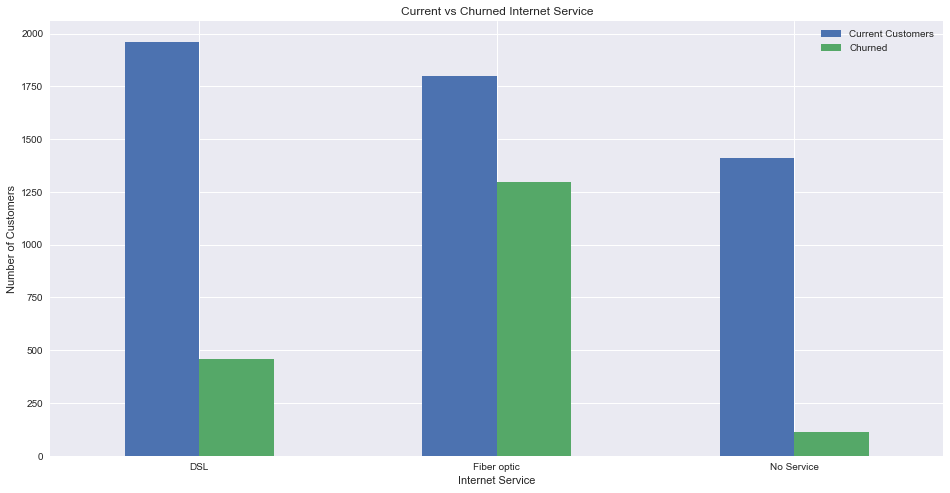

In [73]:
eda7.plot(kind='bar',
          x='internet_service',
          title='Current vs Churned Internet Service',
          figsize=[16,8],
         )

plt.xticks(rotation= 0)
plt.xlabel('Internet Service')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])
plt.show()

The most popular internet service was DSL, followed by fiber optic, with no internet service as the least popular.

The largest proportion and number of customers that have churned are those customers that had the fiber optic internet service, while the lowest proportion and number of customers that have churned did not have an internet service.

In [74]:
eda8 = df_complete.pivot_table(columns='contract_type',
                               index='internet_service',
                               values='customer_id',
                               aggfunc='count'
                              )
eda8.reset_index(inplace=True)

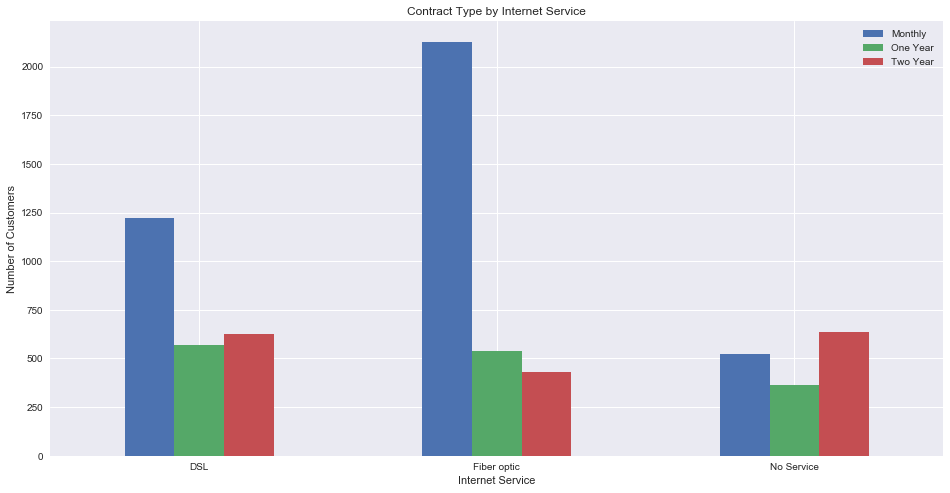

In [75]:
eda8.plot(kind='bar',
          x='internet_service',
          title='Contract Type by Internet Service',
          figsize=[16,8],
         )

plt.xticks(rotation= 0)
plt.xlabel('Internet Service')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])
plt.show()

The most popular contract type by a fair margin is the monthly or month-to-month plan, where the total number of each one and two-year contracts are relatively similar. The most popular option out of the shown combinations is the monthly plan on fiber optic internet, which based on previous information presented - both monthly contracts and fiber optic internet service yielding higher numbers of churned customers, the high degree of short term contracts makes sense.

In [76]:
eda9a = df_complete.pivot_table(columns='churned',
                               index='online_security',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9a.reset_index(inplace=True)

eda9b = df_complete.pivot_table(columns='churned',
                               index='online_backup',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9b.reset_index(inplace=True)

eda9c = df_complete.pivot_table(columns='churned',
                               index='device_protection',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9c.reset_index(inplace=True)

eda9d = df_complete.pivot_table(columns='churned',
                               index='tech_support',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9d.reset_index(inplace=True)

eda9e = df_complete.pivot_table(columns='churned',
                               index='streaming_tv',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9e.reset_index(inplace=True)

eda9f = df_complete.pivot_table(columns='churned',
                               index='streaming_movies',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9f.reset_index(inplace=True)

eda9g = df_complete.pivot_table(columns='churned',
                               index='multiple_lines',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda9g.reset_index(inplace=True)

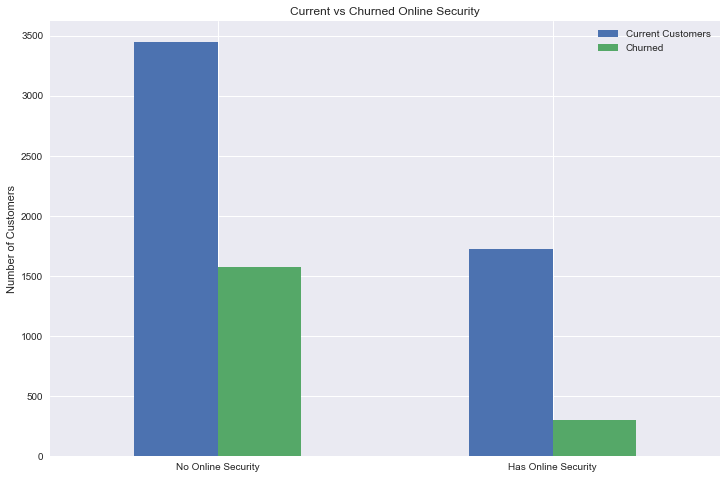

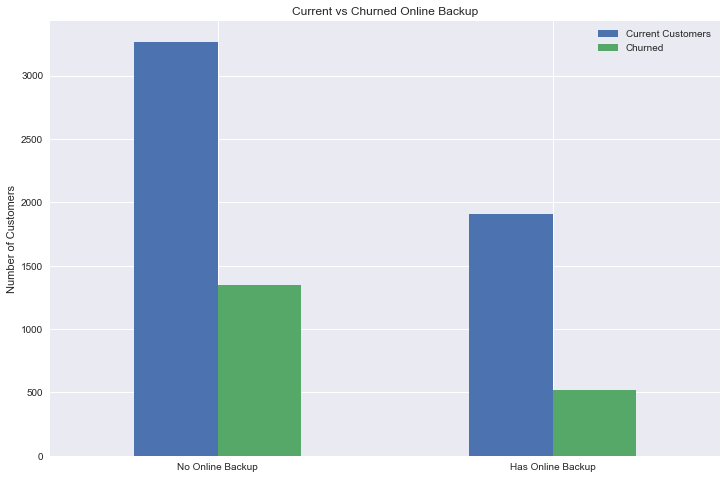

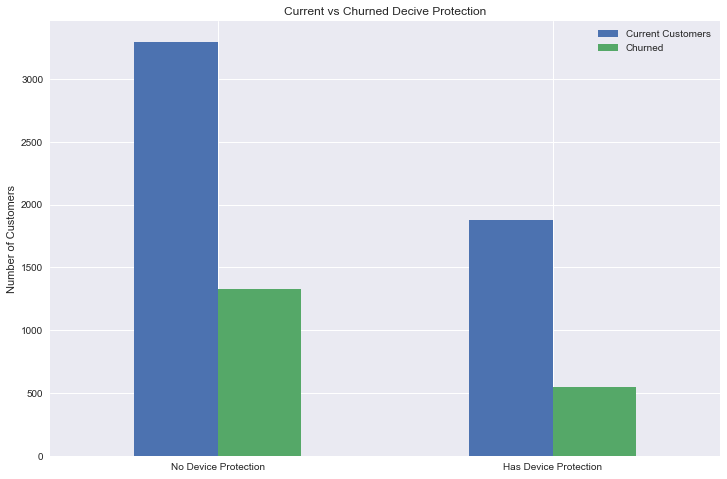

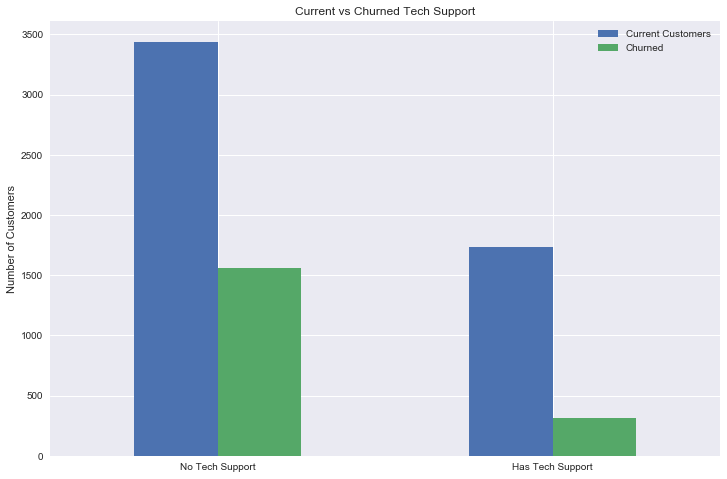

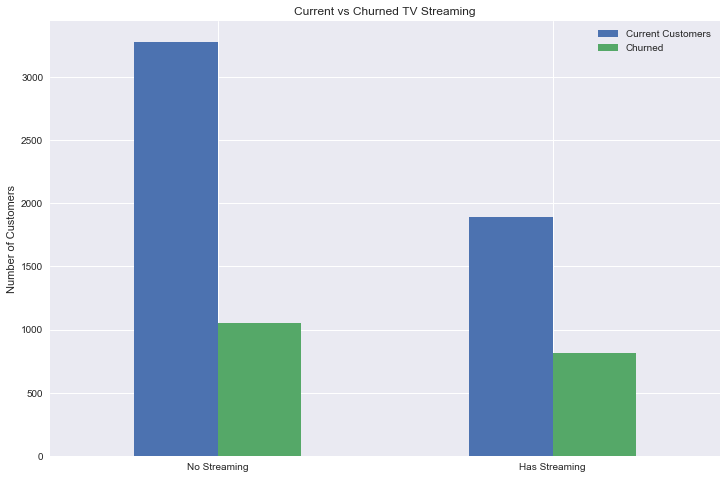

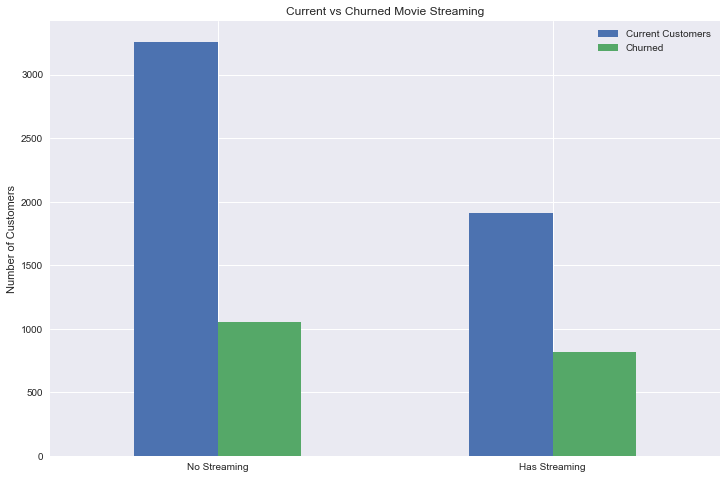

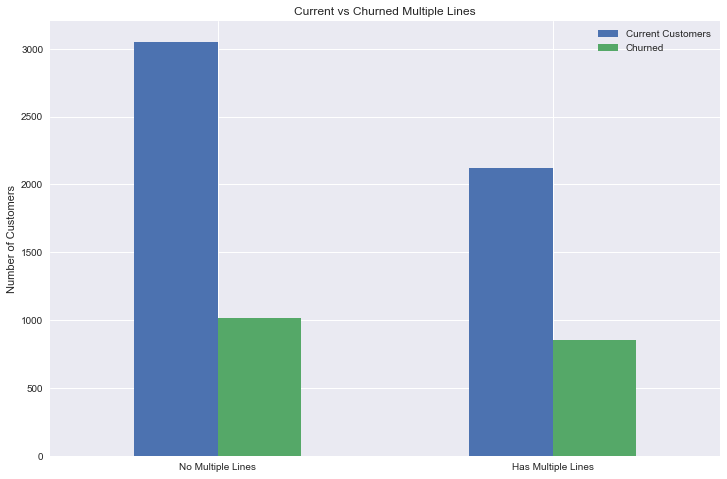

In [77]:
eda9a.plot(kind='bar',
           x='online_security',
           title='Current vs Churned Online Security',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Security', 'Has Online Security'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9b.plot(kind='bar',
           x='online_backup',
           title='Current vs Churned Online Backup',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Backup', 'Has Online Backup'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9c.plot(kind='bar',
           x='device_protection',
           title='Current vs Churned Decive Protection',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Device Protection', 'Has Device Protection'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9d.plot(kind='bar',
           x='tech_support',
           title='Current vs Churned Tech Support',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Tech Support', 'Has Tech Support'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9e.plot(kind='bar',
           x='streaming_tv',
           title='Current vs Churned TV Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9f.plot(kind='bar',
           x='streaming_movies',
           title='Current vs Churned Movie Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda9g.plot(kind='bar',
           x='multiple_lines',
           title='Current vs Churned Multiple Lines',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Has Multiple Lines'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

plt.show()

Customers that have online security, online backup, device protection, and tech suport show to churn at a lower proportion than those that do not. This could be because they have more services that they utilize and benefit from.

The other three, tv streaming, movie streaming, and multiple lines show a slightly higher proportion of churning that have those services, though not to a great degree as they fall within normal proportions that we have seen before. So there is unlikely to be a correlation between these services individually and a customer churning.

In [78]:
eda10a = df_complete.pivot_table(columns='contract_type',
                               index='online_security',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10a.reset_index(inplace=True)

eda10b = df_complete.pivot_table(columns='contract_type',
                               index='online_backup',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10b.reset_index(inplace=True)

eda10c = df_complete.pivot_table(columns='contract_type',
                               index='device_protection',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10c.reset_index(inplace=True)

eda10d = df_complete.pivot_table(columns='contract_type',
                               index='tech_support',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10d.reset_index(inplace=True)


eda10e = df_complete.pivot_table(columns='contract_type',
                               index='streaming_tv',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10e.reset_index(inplace=True)

eda10f = df_complete.pivot_table(columns='contract_type',
                               index='streaming_movies',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10f.reset_index(inplace=True)

eda10g = df_complete.pivot_table(columns='contract_type',
                               index='multiple_lines',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda10g.reset_index(inplace=True)

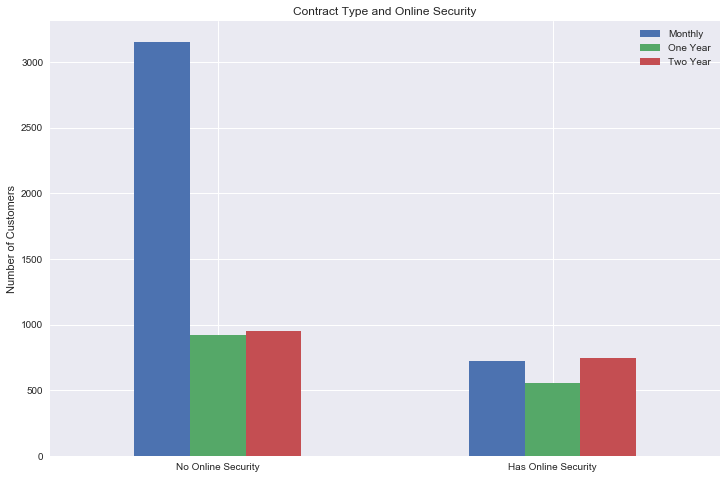

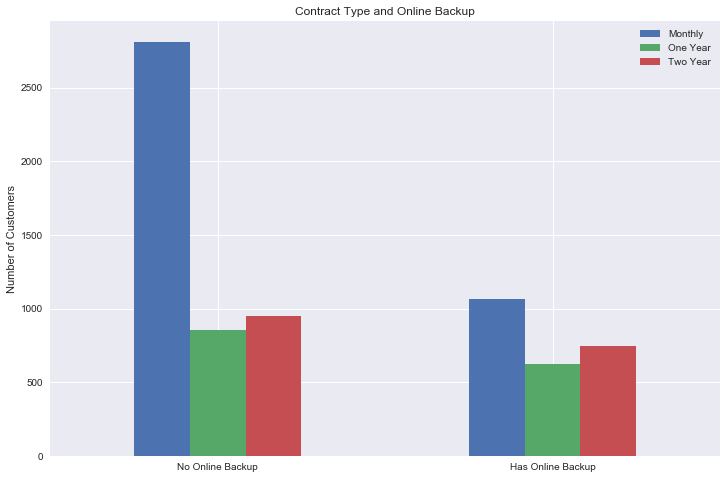

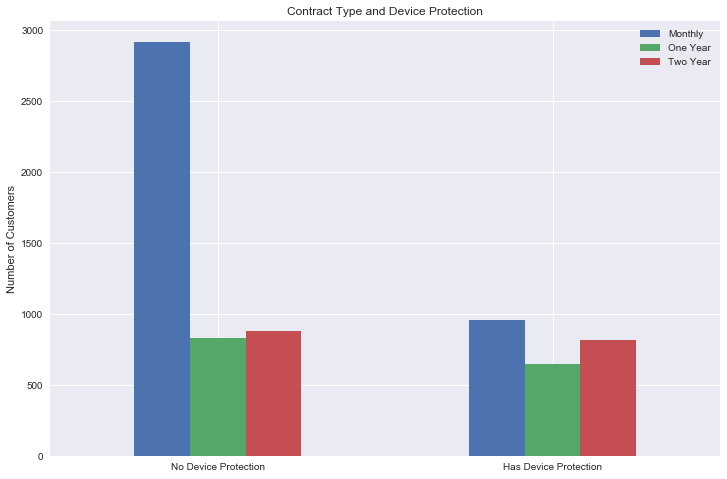

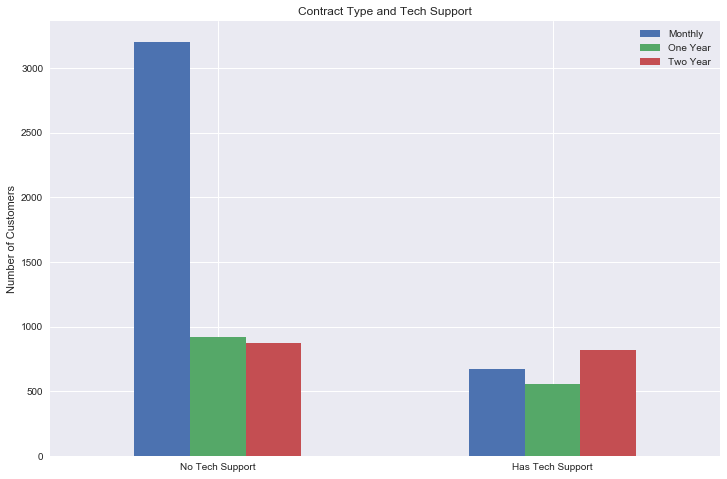

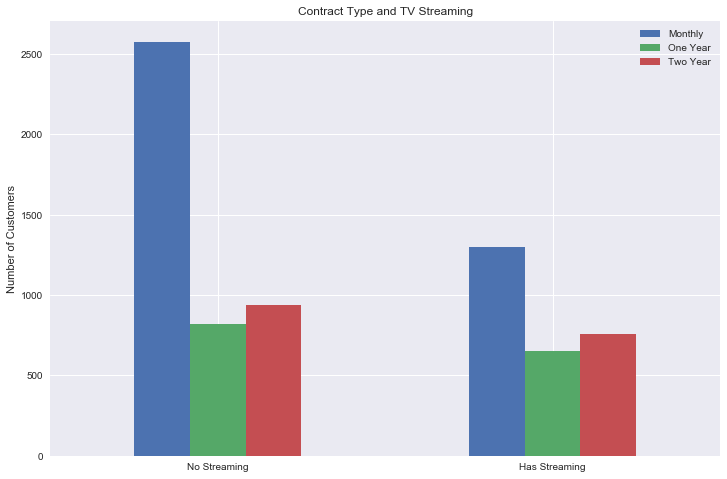

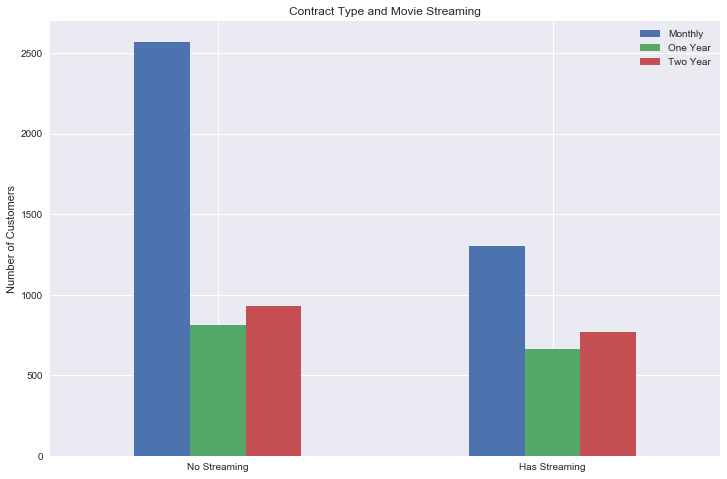

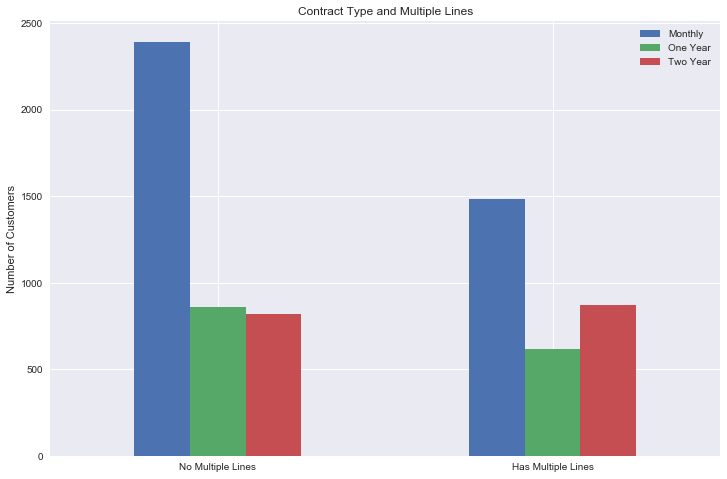

In [79]:
eda10a.plot(kind='bar',
           x='online_security',
           title='Contract Type and Online Security',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Security', 'Has Online Security'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10b.plot(kind='bar',
           x='online_backup',
           title='Contract Type and Online Backup',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Backup', 'Has Online Backup'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10c.plot(kind='bar',
           x='device_protection',
           title='Contract Type and Device Protection',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Device Protection', 'Has Device Protection'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10d.plot(kind='bar',
           x='tech_support',
           title='Contract Type and Tech Support',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Tech Support', 'Has Tech Support'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10e.plot(kind='bar',
           x='streaming_tv',
           title='Contract Type and TV Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10f.plot(kind='bar',
           x='streaming_movies',
           title='Contract Type and Movie Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda10g.plot(kind='bar',
           x='multiple_lines',
           title='Contract Type and Multiple Lines',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Has Multiple Lines'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])



plt.show()

A higher proportion of customers that have one or two year contracts have additional services such as online security or tech support. There is a slightly higher than normal proportion for services like streaming and multiple lines as well, but not to the degree that the contraact types for those that have such services are comparable.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very nice EDA!

</div>

## Model Training

### Load libraries for Machine Learning

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [81]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [83]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [84]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [85]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It's better to install libraries/make imports at the start of the notebook to avoid a situation where you have to redo potentially heavy calculations 

</div>

### Feature Engineering

In [86]:
# Create column for has_internet as some customers do not
has_internet = df_complete['internet_service']
df_complete['has_internet'] = has_internet
df_complete['has_internet'] = df_complete['has_internet'].where(df_complete['has_internet'] != 'DSL', 1)
df_complete['has_internet'] = df_complete['has_internet'].where(df_complete['has_internet'] != 'Fiber optic', 1)
df_complete['has_internet'] = df_complete['has_internet'].where(df_complete['has_internet'] != 'No Service', 0)
df_complete['has_internet'] = df_complete['has_internet'].astype(int)

In [87]:
# Define contract length based on latest begin_date
now = df_complete['begin_date'].max()
df_complete['end_date'] = df_complete['end_date'].fillna(now)
length = ((df_complete['end_date'] - df_complete['begin_date']) / np.timedelta64(1, 'M'))
df_complete['tenure'] = length.round()
df_complete['tenure'] = df_complete['tenure'].astype(int)

In [88]:
# Create number of services column
df_complete['number_of_services'] = df_complete['online_security'] + df_complete['online_backup'] + df_complete['device_protection'] + df_complete['tech_support'] + df_complete['streaming_tv'] + df_complete['streaming_movies'] + df_complete['has_internet'] + df_complete['multiple_lines'] + df_complete['phone_service']
df_complete['number_of_services'] = df_complete['number_of_services'].astype(int)

In [89]:
# Create column of remaining months in contract
remaining_months = []

for index, row in df_complete.iterrows():
    if row['contract_type'] == 'Monthly':
        remaining_months.append(0)
    elif row['contract_type'] == 'One year':
        if row['tenure'] <= 12:
            months = 12 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 12 and row['tenure'] <= 24:
            months = 24 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 24 and row['tenure'] <= 36:
            months = 36 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 36 and row['tenure'] <= 48:
            months = 48 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 48 and row['tenure'] <= 60:
            months = 60 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 60 and row['tenure'] <= 72:
            months = 72 - row['tenure']
            remaining_months.append(months)
    elif row['contract_type'] == 'Two year':
        if row['tenure'] <= 24:
            months = 24 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 24 and row['tenure'] <= 48:
            months = 48 - row['tenure']
            remaining_months.append(months)
        elif row['tenure'] > 48 and row['tenure'] <= 72:
            months = 72 - row['tenure']
            remaining_months.append(months)

df_complete['remaining_months'] = remaining_months
df_complete['remaining_months'] = df_complete['remaining_months'].astype(int)

In [90]:
# Create average charge based on total_charges and tenure
df_complete['average_charge'] = (df_complete['total_charges'] / df_complete['tenure']).round(2)
median = df_complete['average_charge'].median()
df_complete['average_charge'] = df_complete['average_charge'].fillna(median)

In [91]:
# Calculate additional_charges based on difference between total_charges and monthly_charges times tenure
df_complete['additional_charges'] = (df_complete['total_charges'] - (df_complete['monthly_charges'] * df_complete['tenure']))

In [92]:
# Calculate price per service
df_complete['price_per_service'] = (df_complete['monthly_charges'] / df_complete['number_of_services'])

Using existing features, a number of extrapolations were made to create additional measurements beyond what was provided in the data set.

In [93]:
# Create a number of variables on mathmatical transformations to aid in model fitting
df_complete['variable_a'] = np.sqrt(df_complete['monthly_charges']) * df_complete['number_of_services']
df_complete['variable_b'] = np.sqrt(df_complete['tenure']) * df_complete['number_of_services']
df_complete['variable_c'] = np.sqrt(df_complete['monthly_charges'] * df_complete['number_of_services'])
df_complete['variable_d'] = np.sqrt(df_complete['tenure'] * df_complete['number_of_services'])
df_complete['variable_e'] = np.sqrt(df_complete['number_of_services']) / (df_complete['remaining_months'] + 1)
df_complete['variable_f'] = np.sqrt(df_complete['monthly_charges']) / (df_complete['has_internet'] + df_complete['phone_service'])
df_complete['variable_g'] = df_complete['number_of_services'] / np.sqrt(df_complete['tenure'] + 1)
df_complete['variable_h'] = np.sqrt(df_complete['number_of_services']) / df_complete['monthly_charges']
df_complete['variable_i'] = df_complete['price_per_service'] * df_complete['tenure']


Beyond the additional columns added previously which hold some degree of information for interpretation at a glance, nine new variables were created using the exiting columns using mathmatic transformation to help improve model performance.

In [94]:
# Function for replacing outliers using churn/not churn as the delineator, replacing them with appropriate medians
def replace_outliers(df, x_column):
    df_a = df[df['churned'] == 1]
    median_a = df_a[x_column].median()
    std_a = df_a[x_column].std()
    
    df_b = df[df['churned'] == 0]
    median_b = df_b[x_column].median()
    std_b = df_b[x_column].std()
    
    for index, row in df.iterrows():
        if row['churned'] == 1:
            if np.abs(row[x_column] - median_a) > 2 * std_a:
                df.at[index, x_column] = median_a
    
        if row['churned'] == 0:
            if np.abs(row[x_column] - median_b) > 2 * std_b:
                df.at[index, x_column] = median_b
                
    return df

In [95]:
# Remove outliers with the function
df_complete = replace_outliers(df_complete, 'monthly_charges')
df_complete = replace_outliers(df_complete, 'total_charges')
df_complete = replace_outliers(df_complete, 'average_charge')
df_complete = replace_outliers(df_complete, 'additional_charges')
df_complete = replace_outliers(df_complete, 'price_per_service')
df_complete = replace_outliers(df_complete, 'variable_a')
df_complete = replace_outliers(df_complete, 'variable_b')
df_complete = replace_outliers(df_complete, 'variable_c')
df_complete = replace_outliers(df_complete, 'variable_d')
df_complete = replace_outliers(df_complete, 'variable_e')
df_complete = replace_outliers(df_complete, 'variable_f')
df_complete = replace_outliers(df_complete, 'variable_g')
df_complete = replace_outliers(df_complete, 'variable_h')

# Second outlier regularization on variable h increases performance
df_complete = replace_outliers(df_complete, 'variable_h')

A function was created and used to remove outliers, replacing them with median values for the columns. They were delineated by churned or not churned values - applying a blind dataset, or one without churn values known to predict, would still work using the median values for each group generated by this known dataset.

Through testing, it was found that running the `variable_h` column through the `replace_outlier` function increased performance, so it remained as such for model fitting and testing.

In [96]:
# Drop unused columns and OHE
data = df_complete.drop(['customer_id', 'begin_date', 'end_date', 'contract_duration_months'], axis=1)
data_ohe = pd.get_dummies(data, drop_first=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job on feature engineering!

</div>

### Train/Test Split

In [97]:
train, valid = train_test_split(data_ohe, test_size=0.2, random_state=42, stratify=data_ohe['churned'])
train, test = train_test_split(train, test_size=0.25, random_state=42, stratify=train['churned'])

The provided data has been split into training, validation, and testing data at a 3:1:1 ratio.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data split is reasonable

</div>

#### Verify distribution

In [98]:
display(train['churned'].value_counts())
display(valid['churned'].value_counts())
display(test['churned'].value_counts())

0    3104
1    1121
Name: churned, dtype: int64

0    1035
1     374
Name: churned, dtype: int64

0    1035
1     374
Name: churned, dtype: int64

In [99]:
display(1121/3104)
display(374/1035)

0.36114690721649484

0.36135265700483093

The training, validation, and test sets are approximately 36% churned customers in each of the datasets.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good!

</div>

#### Define Features and Target

In [100]:
features_train = train.drop('churned', axis=1)
target_train = train['churned']
features_valid = valid.drop('churned', axis=1)
target_valid = valid['churned']
features_test = test.drop('churned', axis=1)
target_test = test['churned']

`churned` columns has been set to be the target for the models as this is the value that we are seeking to determine, or predict through the use of the models.

#### Scale numerical columns

In [101]:
# Scale numerical data
numeric = ['monthly_charges','total_charges', 'tenure', 'number_of_services', 'remaining_months', 'average_charge', 'additional_charges', 'variable_a', 'variable_b', 'variable_c', 'variable_d', 'variable_e', 'variable_f', 'variable_g', 'variable_h', 'variable_i']
# 'charges_difference', , 'number_of_services'
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Numerical data has been scaled/normaalized in order to improve performance in model training/assessment.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Scaling was applied correctly

</div>

### Train Models

#### Logistic Regression

In [102]:
lr_model = LogisticRegression()
lr_model.fit(features_train, target_train)
#scores = cross_val_score(lr_model, features_train, target_train, cv=8, scoring='roc_auc')
#lr_train_score = sum(scores) / len(scores)
lr_val_predict = lr_model.predict(features_valid)
lr_valid_score = roc_auc_score(target_valid, lr_val_predict)

C:\Users\houle\anaconda3\envs\praktikum_env\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [103]:
lr_predictions_test = lr_model.predict(features_test)

lr_test_score = roc_auc_score(target_test, lr_predictions_test)

<div class="alert alert-warning">
<b>Reviewer's comment</b>

There is a problem with ROC-AUC calculation throughout the project: to get the true ROC-AUC value we need to use probabilities (method `predict_proba`), not binary predictions (method `predict`). The reason is that the ROC curve is constructed by varying the threshold of assigning the positive class between 0 and 1, and for binary predictions the threshold is predefined

</div>

In [104]:
#display("Logistic Regression Training ROC-AUC:", lr_train_score)
display("Logistic Regression Validation ROC-AUC:", lr_valid_score)
display("Logistic Regression Test ROC-AUC:", lr_test_score)

'Logistic Regression Validation ROC-AUC:'

0.8561536076881345

'Logistic Regression Test ROC-AUC:'

0.8389198894313984

The Logistic Regression model is the most simple of those we will train, and it will act like a baseline for the performance of the models trained below.

Our baseline is set with a Validation dataset ROC-AUC score of 0.856, and a Test dataset ROC-AUC score of 0.838 which repersent a moderately high level of accuracy and precision with the Logistic Regression model, however, models using more complex algorithms should perform better.

#### Decision Tree Classifier

In [105]:
### Tuning Hyperparameters

dtc_model = None
dtc_val_score = 0
dtc_best_depth = 0

for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=759638, max_depth=depth)
    model.fit(features_train, target_train)
    #scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
    #result = sum(scores) / len(scores)
    dtc_val_predict = model.predict(features_valid)
    result = roc_auc_score(target_valid, dtc_val_predict)
    if result > dtc_val_score:
        dtc_model = model
        dtc_val_score = result
        dtc_best_depth = depth

In [106]:
#dtc_model = DecisionTreeClassifier(random_state=759638, max_depth=5)
#dtc_model.fit(features_train, target_train)
#scores = cross_val_score(dtc_model, features_train, target_train, cv=8, scoring='roc_auc')
#dtc_train_score = sum(scores) / len(scores)

In [107]:
dtc_predictions_test = dtc_model.predict(features_test)

dtc_test_score = roc_auc_score(target_test, dtc_predictions_test)

In [108]:
display("Decission Tree Classifier Depth:", dtc_best_depth)
display("Decission Tree Classifier Validation ROC-AUC:", dtc_val_score)
display("Decission Tree Classifier Test ROC-AUC:", dtc_test_score)

'Decission Tree Classifier Depth:'

15

'Decission Tree Classifier Validation ROC-AUC:'

0.8845203957735928

'Decission Tree Classifier Test ROC-AUC:'

0.8849246945154874

With a depth of 15, the Validation dataset ROC-AUC score is 0.885, and the Test dataset ROC-AUC score is also 0.885 indicating there wasn't overfitting that occured as two seperate datasets performed equally well. Being that the Decision Tree Classifier scored 3-5 points (1 point being 0.01) better, and having reached the threshold for aa high performing model, this is a good improvement on the previously created Logistic Regression model.

#### Random Forest Classifier

In [109]:
### Tuning Hyperparameters

rfc_model = None
rfc_val_score = 0
rfc_best_est = 0

for est in range(35, 51):
    model = RandomForestClassifier(random_state=759638, n_estimators=est)
    model.fit(features_train, target_train)
    #scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
    #result = sum(scores) / len(scores)
    rcf_val_predict = model.predict(features_valid)
    result = roc_auc_score(target_valid, rcf_val_predict)
    if result > rfc_val_score:
        rfc_val_score = result
        rfc_best_est = est
        rfc_model = model

In [110]:
#rfc_model = RandomForestClassifier(random_state=759638, n_estimators=198)
#rfc_model.fit(features_train, target_train)
#scores = cross_val_score(rfc_model, features_train, target_train, cv=8, scoring='roc_auc')
#rfc_train_score = sum(scores) / len(scores)

In [111]:
rfc_predictions_test = rfc_model.predict(features_test)

rfc_test_score = roc_auc_score(target_test, rfc_predictions_test)

In [112]:
display("Random Forest Classifier Trees:", rfc_best_est)
display("Random Forest Classifier Validation ROC-AUC:", rfc_val_score)
display("Random Forest Classifier Test ROC-AUC:", rfc_test_score)

'Random Forest Classifier Trees:'

43

'Random Forest Classifier Validation ROC-AUC:'

0.874128755586556

'Random Forest Classifier Test ROC-AUC:'

0.8724547262910434

The Random Forest Classifier having a depth of 43, with a Validation data ROC-AUC of 0.874 and a Test data ROC-AUC score of 0.872 performed better than the Logistic Regression model, but a point worse than the Decision Tree model.

#### LightGMB Gradiant Boosted Decision Tree Classifier

In [113]:
### Tuning Hyperparameters before Optuna used

#bdtc_model = None
#bdtc_val_score = 0

#for learn in range (4, 15):
#    rate = learn/20
#    for leaves in range (2, 11):
#        for est in range(1, 51):
#            for fraction in range(5,16):
#                frac = fraction/20
#                model = LGBMClassifier(boosting_type='gbdt', 
#                                       num_leaves=leaves, 
#                                       max_depth=500, 
#                                       learning_rate=rate, 
#                                       n_estimators=est, 
#                                       objective='binary',
#                                      )
#                model.fit(features_train, target_train)
                #scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
                #result = sum(scores) / len(scores)
#                bdtc_val_predict = model.predict(features_valid)
#                result = roc_auc_score(target_valid, bdtc_val_predict)
#                if result > bdtc_val_score:
#                    bdtc_val_score = result
#                    bdtc_est = est
#                    bdtc_learning_rate = rate
#                    bdtc_model = model
#                    bdtc_leaves = leaves
#                    bdtc_frac = frac

In [114]:
### Tuning hyperparameters using Optuna

#def bdtc(trial):
#    learn = trial.suggest_float('learn', 0.01, 1.0, step=0.01)
#    leaves = trial.suggest_int('leaves', 2, 100)
#    est = trial.suggest_int('est', 1, 500)
#    fraction = trial.suggest_float('fraction', 0.1, 1.0, step=0.1)
#    
#    model = LGBMClassifier(
#        boosting_type='gbdt', 
#        num_leaves=leaves, 
#        max_depth=500, 
#        learning_rate=learn, 
#        n_estimators=est, 
#        subsample=fraction,
#        objective='binary'
#    )
#    model.fit(features_train, target_train)
#    
#    bdtc_val_predict = model.predict(features_valid)
#    result = roc_auc_score(target_valid, bdtc_val_predict)
#    
#    return result

#study = optuna.create_study(direction='maximize')
#study.optimize(bdtc, n_trials=1000)

#best_params = study.best_params
#bdtc_model = LGBMClassifier(
#    boosting_type='gbdt', 
#    num_leaves=best_params['leaves'], 
#    max_depth=500, 
#    learning_rate=best_params['learn'], 
#    n_estimators=best_params['est'], 
#    subsample=best_params['fraction'],
#    objective='binary'
#)

#bdtc_model.fit(features_train, target_train)

In [115]:
#bdtc_model = LGBMClassifier(boosting_type='gbdt', 
#                            num_leaves=2, 
#                            max_depth=500, 
#                            learning_rate=0.3, 
#                            n_estimators=145, 
#                            objective='binary',
#                            is_unbalanced=True,
#                            feature_fraction=frac
#                           )
#bdtc_model.fit(features_train, target_train)
#scores = cross_val_score(bdtc_model, features_train, target_train, cv=8, scoring='roc_auc')
#bdtc_train_score = sum(scores) / len(scores)

In [116]:
bdtc_model = LGBMClassifier(boosting_type='gbdt', 
                            num_leaves=2, 
                            max_depth=500, 
                            learning_rate=0.51, 
                            n_estimators=256, 
                            subsample=0.4,
                            objective='binary'
                           )
bdtc_model.fit(features_train, target_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3549
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265325 -> initscore=-1.018470
[LightGBM] [Info] Start training from score -1.018470


LGBMClassifier(learning_rate=0.51, max_depth=500, n_estimators=256,
               num_leaves=2, objective='binary', subsample=0.4)

In [117]:
bdtc_predictions_val = bdtc_model.predict(features_valid)

bdtc_val_score = roc_auc_score(target_valid, bdtc_predictions_val)

In [118]:
bdtc_predictions_test = bdtc_model.predict(features_test)

bdtc_test_score = roc_auc_score(target_test, bdtc_predictions_test)

In [119]:
#display("Gradiant Boosted Decission Tree Classifier Tree feature_fraction:", bdtc_frac)
#display("Gradiant Boosted Decission Tree Classifier Tree estimators:", bdtc_est)
#display("Gradiant Boosted Decission Tree Classifier Tree leaves:", bdtc_leaves)
#display("Gradiant Boosted Decission Tree Classifier Tree learning rate:", bdtc_learning_rate)

display("Gradiant Boosted Decission Tree Classifier Validation ROC-AUC:", bdtc_val_score)
display("Gradiant Boosted Decission Tree Classifier Test ROC-AUC:", bdtc_test_score)

'Gradiant Boosted Decission Tree Classifier Validation ROC-AUC:'

0.8949236611640704

'Gradiant Boosted Decission Tree Classifier Test ROC-AUC:'

0.8936203466894005

Performing better than the previous three models, as predicted, the Gradiant Boosted Decision Tree model showed some improvement on the prediction task. The Validation data ROC-AUC score is 0.895 and the Test data ROC-AUC score is 0.894, which shows a high degree of accuracy and precission in the prediction of churned customers.

#### LightGMB Gradiant Boosted DART Classifier

In [120]:
### Tuning Hyperparameters before Optuna used

#dart_model = None
#dart_val_score = 0

#for learn in range (8, 13):
#    rate = learn/20
#    for leaves in range (2, 6):
#        for est in range (140, 251, 5):
#            for fraction in range(5,16):
#                frac = fraction/20
#                model = LGBMClassifier(boosting_type='dart', 
#                                       num_leaves=leaves, 
#                                       max_depth=500, 
#                                       learning_rate=rate, 
#                                       n_estimators=est, 
#                                       objective='binary',
#                                       feature_fraction=frac
#                                      )
#                model.fit(features_train, target_train)
#                dart_val_predict = model.predict(features_valid)
#                result = roc_auc_score(target_valid, dart_val_predict)
                #scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
                #result = sum(scores) / len(scores)
#                if result > dart_val_score:
#                    dart_val_score = result
#                    dart_leaves = leaves
#                    dart_learning_rate = rate
#                    dart_model = model
#                    dart_est = est
#                    dart_frac = frac

In [121]:
### Tuning hyperparameters using Optuna

#def dart(trial):
#    learn = trial.suggest_float('learning_rate', 0.01, 1.0, step=0.01)
#    leaves = trial.suggest_int('num_leaves', 2, 50)
#    est = trial.suggest_int('n_estimators', 50, 300, step=10)
#    fraction = trial.suggest_float('feature_fraction', 0.1, 1.0, step=0.05)
#    
#    model = LGBMClassifier(
#        boosting_type='dart',
#        num_leaves=leaves,
#        max_depth=500,
#        learning_rate=learn,
#        n_estimators=est,
#        objective='binary',
#        feature_fraction=fraction
#    )
#    
#    model.fit(features_train, target_train)
#    dart_val_predict = model.predict(features_valid)
#    result = roc_auc_score(target_valid, dart_val_predict)
#
#    return result

#study = optuna.create_study(direction='maximize')
#study.optimize(dart, n_trials=1000)

#best_params = study.best_params
#dart_learning_rate = best_params['learning_rate']
#dart_leaves = best_params['num_leaves']
#dart_est = best_params['n_estimators']
#dart_frac = best_params['feature_fraction']

#dart_model = LGBMClassifier(
#    boosting_type='dart',
#    num_leaves=dart_leaves,
#    max_depth=500,
#    learning_rate=dart_learning_rate,
#    n_estimators=dart_est,
#    objective='binary',
#    feature_fraction=dart_frac
#)

#dart_model.fit(features_train, target_train)

In [122]:
#dart_model = LGBMClassifier(boosting_type='dart', 
#                            num_leaves=2, 
#                            max_depth=500, 
#                            learning_rate=0.5, 
#                            n_estimators=133, 
#                            objective='binary',
#                            is_unbalanced=True,
#                            feature_fraction=frac
#                           )
#dart_model.fit(features_train, target_train)
#scores = cross_val_score(dart_model, features_train, target_train, cv=8, scoring='roc_auc')
#dart_val_predict = model.predict(features_valid)
#dart_val_score = roc_auc_score(target_valid, dart_val_predict)
#dart_train_score = sum(scores) / len(scores)

In [123]:
dart_model = LGBMClassifier(boosting_type='dart', 
                            num_leaves=21, 
                            max_depth=500, 
                            learning_rate=0.11, 
                            n_estimators=100, 
                            objective='binary',
                            is_unbalanced=True,
                            feature_fraction=0.55
                           )
dart_model.fit(features_train, target_train)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3549
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265325 -> initscore=-1.018470
[LightGBM] [Info] Start training from score -1.018470


LGBMClassifier(boosting_type='dart', feature_fraction=0.55, is_unbalanced=True,
               learning_rate=0.11, max_depth=500, num_leaves=21,
               objective='binary')

In [124]:
dart_predictions_val = dart_model.predict(features_valid)

dart_val_score = roc_auc_score(target_valid, dart_predictions_val)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55


In [125]:
dart_predictions = dart_model.predict(features_test)

dart_test_score = roc_auc_score(target_test, dart_predictions)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55


In [126]:
#display("Gradiant Boosted DART Classifier Tree feature fraction:", dart_frac)
#display("Gradiant Boosted DART Classifier Tree estimators:", dart_est)
#display("Gradiant Boosted DART Classifier Tree leaves:", dart_leaves)
#display("Gradiant Boosted DART Classifier Tree learning rate:", dart_learning_rate)

display("Gradiant Boosted DART Classifier Validation ROC-AUC:", dart_val_score)
display("Gradiant Boosted DART Classifier Test ROC-AUC:", dart_test_score)

'Gradiant Boosted DART Classifier Validation ROC-AUC:'

0.8964853134929862

'Gradiant Boosted DART Classifier Test ROC-AUC:'

0.885419411506368

Performing better than the previous three non-boosted models, as predicted, the Gradiant Boosted DART model showed some improvement on the prediction task, though was outperformed by the previous Gradiant Boosted Decision Tree model, even if by the slightest margin. The Validation data ROC-AUC score is 0.896 and the Test data ROC-AUC score is 0.885, which shows a high degree of accuracy and precission in the prediction of churned customers.

#### CatBoost Classifier

In [127]:
### Tuning hyperparameters before Optuna used

#cbc_model = None
#cbc_leaves = 0
#cbc_learning_rate = 0
#cbc_val_score = 0

#for learn in range(1, 8):
#    rate = learn / 20
#    for depth in range(16, 17):
#        for est in range(50, 61):
#            model = CatBoostClassifier(
#                iterations=est,
#                learning_rate=rate,
#                depth=depth,
#                loss_function='Logloss',
#                verbose=False,
#                random_state=759638
#                )
#            model.fit(features_train, target_train, eval_set=(features_train, target_train))
#            cbc_val_predict = model.predict(features_valid)
#            result = roc_auc_score(target_valid, cbc_val_predict)
            #scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
            #result = np.mean(scores)
#            if result > cbc_val_score:
#                cbc_val_score = result
#                cbc_depth = depth
#                cbc_learning_rate = rate
#                cbc_model = model
#                cbc_est = est

In [128]:
### Hyperparameter tuning using Optuna

#def cbc(trial):
#    learn = trial.suggest_float('learning_rate', 0.001, 0.5, step=0.001)
#    depth = trial.suggest_int('depth', 3, 16)
#    est = trial.suggest_int('n_estimators', 50, 500)
#    
#    model = CatBoostClassifier(
#        iterations=est,
#        learning_rate=learn,
#        depth=depth,
#        loss_function='Logloss',
#        verbose=False,
#        random_seed=42
#    )
#    
#    model.fit(features_train, target_train, eval_set=(features_valid, target_valid), early_stopping_rounds=20, verbose=False)
#    cbc_val_predict = model.predict(features_valid)
#    result = roc_auc_score(target_valid, cbc_val_predict)
#    return result

#study = optuna.create_study(direction='maximize')
#study.optimize(cbc, n_trials=1000)

#best_params = study.best_params
#cbc_learning_rate = best_params['learning_rate']
#cbc_depth = best_params['depth']
#cbc_est = best_params['n_estimators']

#cbc_model = CatBoostClassifier(
#    iterations=cbc_est,
#    learning_rate=cbc_learning_rate,
#    depth=cbc_depth,
#    loss_function='Logloss',
#    verbose=False,
#    random_seed=42
#)

#cbc_model.fit(features_train, target_train, eval_set=(features_valid, target_valid), early_stopping_rounds=20, verbose=False)

In [129]:
#cbc_model = CatBoostClassifier(iterations=est,
#                               learning_rate=rate,
#                               depth=leaves,
#                               loss_function='Logloss',
#                               verbose=False)
#cbc_model.fit(features_train, target_train, eval_set=(features_train, target_train))
#scores = cross_val_score(model, features_train, target_train, cv=8, scoring='roc_auc')
#cbc_train_score = np.mean(scores)
#cbc_val_predict = model.predict(features_valid)
#cbc_val_score = roc_auc_score(target_valid, cbc_val_predict)

In [130]:
cbc_model = CatBoostClassifier(iterations=434,
                               learning_rate=0.464,
                               depth=3,
                               loss_function='Logloss',
                               verbose=False,
                               random_seed=42
                              )

cbc_model.fit(features_train, target_train)

In [131]:
cbc_predictions_val = bdtc_model.predict(features_valid)

cbc_val_score = roc_auc_score(target_valid, cbc_predictions_val)

In [132]:
cbc_predictions = cbc_model.predict(features_test)

cbc_test_score = roc_auc_score(target_test, cbc_predictions)

In [133]:
#display("CatBoost Classifier Tree learning rate:", cbc_learning_rate)
#display("CatBoost Classifier Tree depth:", cbc_depth)
#display("CatBoost Classifier Tree iterations:", cbc_est)

display("CatBoost Classifier Validation ROC-AUC:", cbc_val_score)
display("CatBoost Classifier Test ROC-AUC:", cbc_test_score)

'CatBoost Classifier Validation ROC-AUC:'

0.8949236611640704

'CatBoost Classifier Test ROC-AUC:'

0.8750161461158904

Performing better than the previous three non-boosted models, as predicted, the Gradiant Boosted CatBoost Classifier model showed some improvement on the prediction task, though was outperformed by the previous Gradiant Boosted Decision Tree model, even if by the slightest margin. The Validation data ROC-AUC score is 0.895 and the Test data ROC-AUC score is 0.875, which shows a high degree of accuracy and precission in the prediction of churned customers.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent! You tried a few different models, tuned their hyperparameters and achieved great results!

</div>

## Conclusion

Following our exploratory analysis of the data, where we determined that when the data was observed at a glance, there were only a couple of indicators of customers that were at a higher risk of churning - such as being a senior citizen, or being on a monthly contract rather than one that was more long-term - we engineered the provided data for machine learning.

From the existing columns, we created a number of columns to help in the analysis - some could be observed in such a manner as to be analyszed further, others were the result of mathmatic transformation to represent more abstract variables that would be less useful in a manual analysis.

After numerous rounds of variable creation, and hyperparameter tuning, we produced a good model in the form of a Gradiant Boosted Decision Tree model using the LightGBM library. The final results of the chosen model when applied to the Test data was a ROC-AUC score of 0.8936203466894005.

# Solution Code

### What steps of the plan were performed and what steps were skipped (explain why)?

All steps as laid out by the work plan were achieved. No. 8: "Model Selection" was wrapped into the model evaluation and conclusion of the project as isolating it was not necessary or beneficial to the overall flow as the models were assessed during their training and the Conclusion restated the best model was the Gradiant Boosted Decision Tree model using the Light GBM library.

### What difficulties did you encounter and how did you manage to solve them?

I had two primary difficulties during the project, and one secondary.

The first issue that impacted me greatly was my file being corrupted and losing a good deal of progress I had made. I believe that my local environment through Anaconda also got messed up as I had to reload the environment entirely and pull an old file, making me redo three to four days of work. I started downloading more backups after this incident in case corruption occurred again.

The second issue I ran into was an inability to get my ROC-AUC higher than the low to mid .70s - this was fixed by just taking a breath and explaining box and whisker plots to someone - at which point I realized I did not handle outliers properly. Once I implimented my function to deal with outliers, my results improved greatly.

The secondary issue was the time it took to train my models. I wasn't using the most efficient method of tuning my hyperparameteres, relying on nested loops rather than a more efficient grid search. However, I found a library called Optuna which turned out to be a fantastic resource to tune my hyperparameters. Where a nested loop tune would take three or four hours, I would get better results using Optuna in a fraction of the time. It took on average five to ten minutes to run 1000 iterations with Optuna resulting in fantastic results for my hyperparameters. Setting it up with the appropriate functions also took very little time as well as once I had it written for one boosted model, the other two were near carbon copies with slight variations.

### What were some of the key steps to solving the task?

Some of the key steps were proper preprocessing of the data, this ensured that the four separate dataframes were able to be merged with ease.

The exploratory aanalysis also helped paint a picture that there were very few features that alone had a strong correlation to the targeted churn data. This was key in my feature engineering, both in making new columns that held some degree of significance just looking at them, such as the average monthly charge, or months remaining in the contracts, and the seemingly random variable columns that were mathmatical transformations based on the existing columns, that when looked at alone didn't hold significant value, but aided in creating a strong model.

Handling the outliers properly was also key - it was a hurdle that took me longer than I would have liked, but resulted in significant improvements to the models after they had been appropriately handled.

The final key step in the project was taking the time to tune the hyperparameters of the models rather than just getting "close enough" and using that result. My use of Optuna helped ensure that the models created were tuned to the best they could have been and resulted in high quality models.

### What is your final model and what quality score does it have?

My final model was the Gradiant Boosted Decision Tree Classifier using the LightGBM library. The model with tuned hyperparameters is as follows:

```
bdtc_model = LGBMClassifier(boosting_type='gbdt', 
                            num_leaves=2, 
                            max_depth=500, 
                            learning_rate=0.51, 
                            n_estimators=256, 
                            subsample=0.4,
                            objective='binary'
                           )
```

The results were:

```
Gradiant Boosted Decission Tree Classifier Validation ROC-AUC: 0.8949236611640704

Gradiant Boosted Decission Tree Classifier Test ROC-AUC: 0.8936203466894005
```
The results of both the validation and test data being approximately the same when rounded to two decimals, 0.89, shows that there wasn't a significant degree or any apparent overfitting. And with such a result the model produced was one of high quality.